In [1]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 6.3MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/My Drive/data/ChIP-seq/'
LOG_DIR = '/content/drive/My Drive/dna-nn/embedding-recurrent/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!cp -r '/content/drive/My Drive/dna_nn' .
!ls dna_nn

download.py  load.py


In [5]:
from itertools import product
import gc

from Bio import SeqIO
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

from dna_nn.load import gen_from_fasta

In [6]:
vocab = [' '.join(p) for p in product('ACGT', repeat=1)]
vectorize_layer = keras.layers.experimental.preprocessing.TextVectorization(
    standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
vectorize_layer.adapt(vocab)

In [7]:
def vectorize_text(x, y):
    x_index = vectorize_layer(x)
    return x_index, y

In [8]:
# generators
subset_size = 690 * 190

train_file = DATA_DIR + 'motif_discovery_train.fasta'
test_file = DATA_DIR + 'motif_discovery_test.fasta'
train_gen = gen_from_fasta(train_file, None)
test_gen = gen_from_fasta(test_file, None)

# datasets
bacth_size = 512
prefetch = tf.data.experimental.AUTOTUNE

output_shapes = ((), ())
output_types = (tf.string, tf.float32)

train_ds = Dataset.from_generator(train_gen, output_types, output_shapes)
val_ds = train_ds.skip(subset_size).take(690 * 10)
train_ds = train_ds.take(subset_size) \
            .shuffle(500) \
            .batch(bacth_size) \
            .map(vectorize_text) \
            .prefetch(prefetch)

val_ds = val_ds.map(vectorize_text) \
            .prefetch(prefetch)

test_ds = Dataset.from_generator(test_gen, output_types, output_shapes)
test_ds = test_ds.take(subset_size) \
            .batch(bacth_size) \
            .map(vectorize_text) \
            .prefetch(prefetch)

print('x shape:', train_ds.element_spec[0].shape)
print('y shape:', train_ds.element_spec[1].shape)

x shape: (None, None)
y shape: (None,)


In [10]:
for d in train_ds.take(1):
    print(d[0].shape)

(512, 101)


In [9]:
%%time
x_val, y_val = [], []
for d in val_ds:
    x_val.append(d[0])
    y_val.append(d[1])
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
validation_data = (x_val, y_val)

CPU times: user 28.4 s, sys: 2.71 s, total: 31.1 s
Wall time: 34 s


In [23]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Input(shape=(101)),
    keras.layers.Embedding(101, 256),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(128),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
auc = keras.metrics.AUC()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 101, 256)          25856     
_________________________________________________________________
dropout (Dropout)            (None, 101, 256)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 101, 64)           82176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [24]:
version = 'v1-base'

callbacks = [
    keras.callbacks.CSVLogger(LOG_DIR + f'{version}.csv'),
    keras.callbacks.TensorBoard(log_dir=LOG_DIR + f'log/{version}/'),
    keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: gc.collect(),
        on_train_end=lambda logs: model.save(LOG_DIR + f'{version}.h5')
    ),
]
history = model.fit(train_ds, epochs=30, validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/30
      2/Unknown - 0s 129ms/step - loss: 0.6930 - accuracy: 0.5137 - auc: 0.5050WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0651s vs `on_train_batch_end` time: 0.1961s). Check your callbacks.
257/257 [==============================] - 28s 109ms/step - loss: 0.6932 - accuracy: 0.5068 - auc: 0.5088 - val_loss: 0.6924 - val_accuracy: 0.5123 - val_auc: 0.5180
Epoch 2/30
257/257 [==============================] - 26s 101ms/step - loss: 0.6907 - accuracy: 0.5244 - auc: 0.5353 - val_loss: 0.6868 - val_accuracy: 0.5428 - val_auc: 0.5650
Epoch 3/30
257/257 [==============================] - 26s 102ms/step - loss: 0.6790 - accuracy: 0.5703 - auc: 0.5969 - val_loss: 0.6704 - val_accuracy: 0.5864 - val_auc: 0.6232
Epoch 4/30
257/257 [==============================] - 26s 101ms/step - loss: 0.6589 - accuracy: 0.6071 - auc: 0.6482 - val_loss: 0.6479 - val_accuracy: 0.6322 - val_auc: 0.6846
Epoch 5/30
257/257 [==================

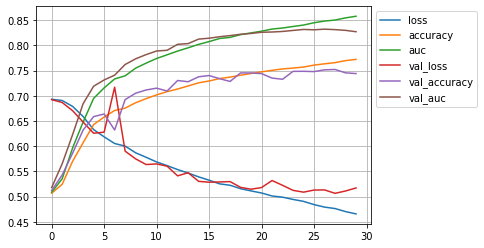

In [25]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [26]:
model.evaluate(test_ds)

257/257 [==============================] - 23s 91ms/step - loss: 0.5212 - accuracy: 0.7443 - auc: 0.8235


[0.5211902260780334, 0.744340181350708, 0.8234620690345764]